# Classifying Character Intensity
- This notebook is part of a series which aims to explore emotional arcs of characters throughout a narrative. This notebook specifically will cover intensity by using a dataset of text labelled by degrees of toxicicity. While the next will aim to model degrees of postive emotions.

## Objective
- Using open soure labelled datasets in combination with data proprocessing and Bidirectional Encoder Representations from Transformers - BERT architecture. BERT is a Transformer-based machine learning technique for natural language processing. 

## Purpose
- Notable insight can be gained from visually reviewing a characters emotional arc it is quick and easy way to undertand and quantify traits of character personailty such as tenacity, empathy, volitility, aversion. 

- Another key point is that a characters arc can be compared to their contemporaries and equally as interesting they can be compared to past versions of themselves. i.e. the arc can continue through a franchise

- Futhermore emotional acrs can help provide a greater understanding where the peaks and dips of the story are located as the dialogue can be a direct reflection of the scene itself, though scene analysis should be used as supplementary data to provide greater context to the dialogue



# Take Aways
- "Toxicicity" is not the ideal label name given the conext of the project and also after review it is far more accurate at capturing the deaired outcome of degrees of "Intensity". This label softens impact of high scores/sensitivity of this label (given the training data label balance) and appears more semantically suitable
- While on a granular level the individual sentences lose the semantic context and have low scores the peaks of impactful sentences nullify this somewhat and when plotted on a graph the generally intensity of "intense" scenes is visible 
- Generally impressed with the robust results achieved with a relativly simplictic model architecture


# Areas for Imporovement
- Like "Toxic" the "identity_hate" tends to overclassify and could benifit from another sampling technuique though changing the label to "personal" suits the results and the objective in this instance
- Can't plot the characters against each other as their scenes where not parsed chronolgically with respect to one another. Next step will parse scenes and then dialogue for this ability and to classify the scene context itself
- Could try BCEWithLogitLoss or other loss functions
- Could add the test data and labels to the training to accuire more training samples

In [2]:
# Install the nom standard  package
!pip install pytorch-lightning
!pip install transformers

     |████████████████████████████████| 839kB 8.0MB/s 
     |████████████████████████████████| 276kB 21.4MB/s 
     |████████████████████████████████| 112kB 25.9MB/s 
     |████████████████████████████████| 184kB 21.8MB/s 
     |████████████████████████████████| 829kB 26.9MB/s 
     |████████████████████████████████| 1.3MB 43.3MB/s 
     |████████████████████████████████| 143kB 47.4MB/s 
     |████████████████████████████████| 296kB 40.9MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=aceb92856ee2a4b7c9163b88f29b5cb364501d8d582be05811b1722fd8948c3c
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=feb185fe9b9031d7eded3675f1e18e5260e0248209e9db18d19ec7177803a10b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML

In [37]:
# Data manipulation Libraries
import pandas as pd
import numpy as np
import re

# data visualization libraries
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
# set some visual params 
rcParams['figure.figsize'] = 15, 5
pd.set_option('display.max_colwidth', 300)



# Neural network 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
seed_everything(seed=32)
# Wont be rounding up so lets drop this
# from pytorch_lightning.metrics.functional.classification import auroc # area under the reciever 

Global seed set to 32


32

In [ ]:
# Check GPU specs
! nvidia-smi

Thu Apr  8 09:25:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Load toxic comment dataset
df = pd.read_csv('/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/Jigsaw Toxic Comments/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


# Investigating Text Data
- Comment length
- Cleaning text data

In [ ]:
# Get the lengths of each comment
lens = [len(x.split()) for x in df['comment_text'].tolist()]

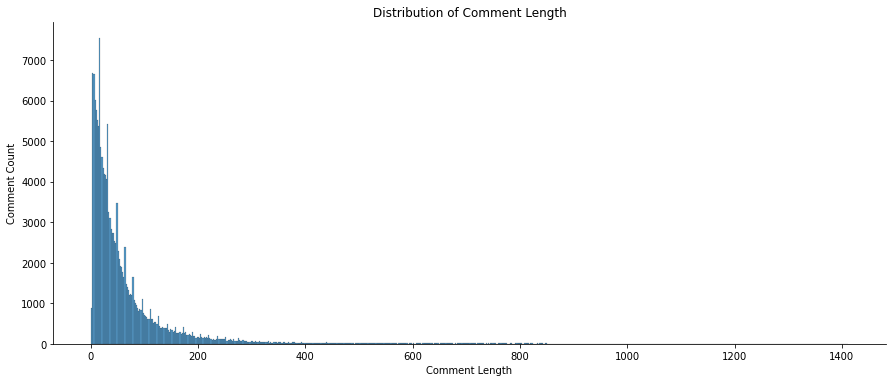

In [ ]:
# Plot length distribution
sns.displot(lens,height=5, aspect=2.5)
plt.xlabel("Comment Length")
plt.ylabel("Comment Count")
plt.title("Distribution of Comment Length")
plt.show()

In [ ]:
# Cleaning text data
# example of patterns found
# df[df['comment_text'].str.contains('http')]
# df[df['comment_text'].str.contains('@')]
# df[df['comment_text'].str.contains('#')]
# df[df['comment_text'].str.contains(':-\)')]


EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

URLPATTERN = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)|http" 

SEQPATTERN = r"(.)\1\1+"

SEQREPLACE = r"\1\1"

# Leaving a few symbols like ? and ! in the text
special_chars = ['"', ':', ';', "_", "#", '@', "~", "|", '{', '}', "*", ">", "<", '\n', '[', ']', '{', '}', '-']



In [ ]:
def preprocess_text(text):
  text = re.sub(URLPATTERN, 'address', text)
  for e in EMOJIS:
    text = text.replace(e, EMOJIS[e])
  for char in special_chars:
    text = text.replace(char, " ")
  text = re.sub(SEQPATTERN, SEQREPLACE, text)

  return text

In [ ]:
df['clean_text'] = df['comment_text'].apply(preprocess_text)

In [ ]:
# df[df['clean_text'].str.contains('https')]
# df[df['comment_text'].str.contains('@')]
# df[df['comment_text'].str.contains('#')]
# df[df['comment_text'].str.contains(':-\)')]

# Investigating Label Distribution
- Single label vs Multilabel

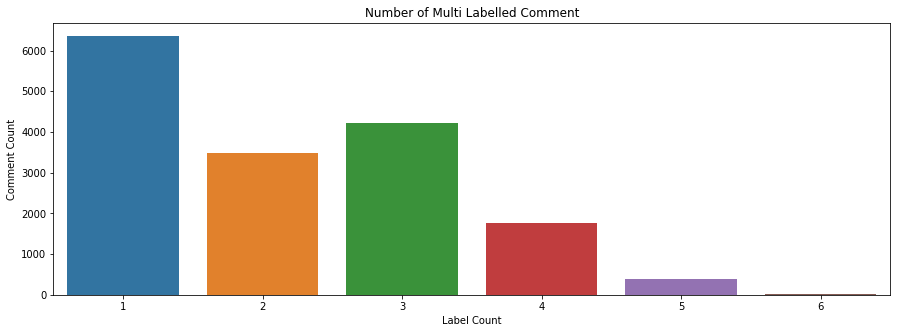

In [ ]:
# Summing the labelled axis 
sums = df.iloc[:, 2:].sum(axis=1)
# Value count for multilabelled entries 
sums_vc = sums.value_counts()

# Removing clean comments
values = sums_vc.iloc[1:]

# Plotting multilabelled entries
sns.barplot(x=values.index, y=values.values)
plt.xlabel("Label Count", fontsize=16)
plt.ylabel("Comment Count",fontsize=12)
plt.title("Number of Multi Labelled Comment",fontsize=12)
plt.show()

# Splitting The Data Train, Val, Test

In [ ]:
# Split the data
train_df, tmp_df = train_test_split(df, test_size=0.3, random_state=32) 
test_df, val_df = train_test_split(tmp_df, test_size=0.5, random_state=32) 
train_df.shape, val_df.shape, test_df.shape

((111699, 9), (23936, 9), (23936, 9))

In [ ]:
# list of the label comments
label_cols = list(df.iloc[:,2:-1].columns)
label_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Investigating Training Data Label Distribution

In [ ]:
train_clean = train_df[train_df[label_cols].sum(axis=1) < 1]
train_toxic = train_df[train_df[label_cols].sum(axis=1) > 0]

len(train_clean), len(train_toxic)

(100271, 11428)

In [ ]:
cols = list(df.iloc[:, 2:-1].columns)  
count = {}
for col in cols:
  count[col] = np.sum(train_toxic[col])
count

{'identity_hate': 1003,
 'insult': 5565,
 'obscene': 5984,
 'severe_toxic': 1143,
 'threat': 317,
 'toxic': 10791}

# Balancing Training Data Label Distribution
- Creating minority class subsets
- Conncatonating subsets to a balanced dataset

In [ ]:
# Balancing out the the dataset by increasing some single and multilabel classes 

obscene_insult = train_toxic[(train_toxic['insult'] == 1) & (train_toxic['obscene'] == 1) & (train_toxic['toxic'] == 0) \
                           & (train_toxic['identity_hate'] == 0) & (train_toxic['threat'] == 0)& (train_toxic['severe_toxic'] == 0)]


# threat_subset = df.loc[df.sum(axis='threat').eq(1)]
threat_subset = train_toxic[(train_toxic['threat'] == 1) & (train_toxic['obscene'] == 0) & (train_toxic['insult'] == 0)]

# hate_subset = df.loc[df.sum(axis='hate').eq(1)]
hate_subset = train_toxic[(train_toxic['identity_hate'] == 1) & (train_toxic['insult'] == 0) & (train_toxic['obscene'] == 0)]

severe = train_toxic[(train_toxic['toxic'] == 1) & (train_toxic['severe_toxic'] == 1) & (train_toxic['obscene'] == 0) & (train_toxic['insult'] == 0)]


print(len('obscene subset length', obscene_insult)'\n',
      len('threat subset length', threat_subset)'\n, 
      len('hate subset length' hate_subset)'\n,
      len('severe subset length', severe))

124
99
144
36


In [ ]:
# Oversampling single and multilabel instances of minority classes 
threat_multi = pd.concat([threat_subset]*40, ignore_index=True)
hate_multi = pd.concat([hate_subset]*30, ignore_index=True)
severe_multi = pd.concat([severe]*100, ignore_index=True)
balanced_toxic = pd.concat([threat_multi, hate_multi, obscene_insult, severe_multi, train_toxic])

print('\ntotal df length')
len(balanced_toxic)


total df length


23432

In [ ]:
# Count the instance of each class
cols = list(df.iloc[:, 2:-1].columns)  
count = {}
for col in cols:
  count[col] = np.sum(balanced_toxic[col])
count

{'identity_hate': 5723,
 'insult': 5689,
 'obscene': 6108,
 'severe_toxic': 5043,
 'threat': 5027,
 'toxic': 20971}

In [ ]:
# concat the balanced toxic df with sample non-toxic
train_samples = pd.concat([
    balanced_toxic,
    train_clean.sample(28000)
])

In [ ]:
# shape of full training dataset
train_samples.shape

(51432, 9)

# Loading The BERT Model

In [ ]:
# Load the bert model for tokenizing and training
bert_model_name = 'bert-base-cased'

bert = BertModel.from_pretrained(bert_model_name, return_dict=True)

tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Creating Dataset Encoder Class
- Encodes data and returns a dictionary
- To be loaded into 

In [ ]:
# Pytorch dataset encoding class
class CommentsDataset(Dataset):
  # Define the class variables and set the attributes
  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int=256):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  # returns length of dataset (standard for pytorch dataset encoder)
  def __len__(self):
    return len(self.data)
  # Indexer function (statndard pytorch dataset encoder)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    # Comment text 
    clean_text = data_row.clean_text
    # Label cols
    labels = data_row[label_cols]

    # Bert encode_plus
    encoding = self.tokenizer.encode_plus(
        clean_text,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Return dictionary of relevant model inputs (plus text, labels)
    return dict(
        clean_text=clean_text,
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        labels=torch.FloatTensor(labels)
    )



In [ ]:
# Test class
train_dataset = ToxicCommentsDataset(train_samples, tokenizer)
# Print index zero comment text, labels, input_id shape (tensor len(256))
sample_item = train_dataset[0]
print(sample_item.keys(), '\n')
print(sample_item['clean_text'], '\n')
print(sample_item['labels'], '\n')
print(sample_item['input_ids'].shape)

dict_keys(['clean_text', 'input_ids', 'attention_mask', 'labels']) 

  Do it and I will cut you 

tensor([1., 0., 0., 1., 0., 0.]) 

torch.Size([256])


In [ ]:
prediction = bert(sample_item['input_ids'].unsqueeze(dim=0), sample_item['attention_mask'].unsqueeze(dim=0))

In [ ]:
# Model outputs two variable hidden state shape and pooled output (usable prediction)
prediction.last_hidden_state.shape, prediction.pooler_output.shape

(torch.Size([1, 256, 768]), torch.Size([1, 768]))

In [ ]:
# Data module class pl.LightningDataModule
class CommentDataModule(pl.LightningDataModule):

  def __init__(self, train_samples, val_df, test_df, tokenizer, batch_size=32, max_token_len=256):
    # Inherit from ToxicCommentDataset
    super().__init__()
    # Define datamodule attributes
    self.train_samples = train_samples
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self):
    # setup function to define the toxic comment datasetsets
    self.train_samples = ToxicCommentsDataset(
      self.train_samples,
      self.tokenizer,
      self.max_token_len
    ) 

    self.val_dataset = ToxicCommentsDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
    
  # Data loader combines a dataset and a sampler and
  #  provides an iterable over the given dataset
  def train_dataloader(self):
    return DataLoader(
        self.train_samples,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size=1,
        num_workers=4
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        num_workers=4
        )
    

In [ ]:
# Batch size for dataloader
batch_size=8
# instatiate data_module
data_module = ToxicCommentDataModule(train_samples, val_df, test_df, tokenizer, batch_size=batch_size)
data_module.setup()

In [ ]:
class CommentClassifier(pl.LightningModule):

  # Interchangable variables will be classes, steps per epoch, n_epochs
  def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None):
    super().__init__() 

    # Assign classifier class attributes BERTModel
    self.bert = BertModel.from_pretrained(bert_model_name, return_dict=True)
    # Fully connected layer with Bert final hidden layer dimensions
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.steps_per_epoch = steps_per_epoch
    self.n_epochs = epochs
    # Measures reconstrution error for numbers between 0-1
    # (must be passed through Sigmoid Function)
    # BCEWITHLOGITLOSS more stable than BCELoss, pos_weight arg = class weight
    self.criterion = nn.BCELoss()

  # Define the forward pass
  def forward(self, input_ids, attention_mask, labels=None):
    # Feed forward BERT model input ids and attention mask
    output = self.bert(input_ids, attention_mask=attention_mask)
    # Final layer pooler output (dimentionality reduced)
    output= self.classifier(output.pooler_output)
    # torch.sigmoid probability function for BCELoss function
    # (Squashes the value of probablility between 0 and 1)
    output = torch.sigmoid(output) 
    loss = 0
    if labels is not None:
      # BinaryCrossEntopy Loss function 
      # output (prediction) and label (ground truth)
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    # define the inputs for the classifier class
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    # feed the inputs to self() - returns the loss and prediction into a dictionary
    loss, outputs = self(input_ids, attention_mask, labels)
    # Record progress bar and lightning logs 
    self.log('train_loss', loss, prog_bar=True, logger=True)
    # return dictionary
    return {'training_loss': loss, 'predictions': outputs, 'labels':labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    # just returen the loss from test and val step
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log('test_loss', loss, prog_bar=True, logger=True)
    # just returen the loss from test and val step
    return loss

  def training_epoch_end(self, outputs):
    # aggregate/collect the outputs from training_step
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output['labels'].detach().cpu():
        labels.append(out_labels)

      for out_predictions in output['predictions'].detach().cpu():
        predictions.append(out_predictions)
    
    # Stack and collect predictions to compute accuracy
    # (MORE INTERESTED IN USING PROBA AS MEASURE OF LABEL STRENGTH)
    labels = torch.stack(labels)    
    predictions = torch.stack(predictions)


  # Configure Pytorch optimizer for BERT model
  # AdamW optimizer and linear_scheduler_with_warmup (Huggingface) | TRIED A FEW COMBINATIONS OF THESE
  def configure_optimizers(self):
    # Set optimizer and steps with recommended parameters (huggingface)
    optimizer = AdamW(self.parameters(), lr=2e-5)
    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
    # set scheduler https://huggingface.co/transformers/main_classes/optimizer_schedules.html
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        warmup_steps,
        total_steps
    )
    # return optimizer, scheduler
    return [optimizer], [scheduler]

In [ ]:
# Define the model __init__ variables
epochs=20
model = CommentClassifier(
    n_classes=6,
    steps_per_epoch = len(train_samples) // batch_size,
    n_epochs = epochs
)

In [ ]:
# Define the Pytorch trainer
trainer = pl.Trainer(max_epochs = epochs,gpus=1, progress_bar_refresh_rate=30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
# Fit the trainer to model and data module
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1

In [ ]:
# fit the trainer to the test data
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.05639807507395744}
--------------------------------------------------------------------------------


[{'test_loss': 0.05639807507395744}]

In [ ]:
# Save checkpoint for training or inference 
trainer.save_checkpoint('/content/drive/MyDrive/Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/Model Checkpoints/clean_256_len_25epochs.ckpt')

In [ ]:
# import shutil

# shutil.rmtree('/content/lightning_logs')

In [ ]:
# Reload saved model
trained_model = ToxicCommentClassifier.load_from_checkpoint('/content/drive/MyDrive/Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/Model Checkpoints/clean_256_len_25epochs.ckpt', n_classes=6)

# Time for some Inference!
This will be manually inspected for accuracy

In [ ]:
# Load the parsed character dialogue
char_df = pd.read_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/godfather_chars.csv")
char_df.head()

,SONNY,HAGEN,MICHAEL
0,"He'll be here Pop, it's still early.",(nodding)\n It will cost.,I told you I had a lot of relatives.
1,"Sandra, watch the kids. They're\n running wild.",Who do I give this job to?,They're waiting to see my father.
2,"Buddy, this is a private party.",Francesco Nippi. His nephew has\n been refused parole. A bad case.,"They're going to talk to my father,\n which means they're going to ask\n him for something, which means they\n better get it right."
3,Goddamn FBI...don't respect nothing.,You understand him better than\n anyone.,Because they know that no Sicilian\n will refuse a request on his\n daughter's wedding day.
4,And Michael?,"Hello Kay. Your father's inside,\n doing some business.\n (privately)\n He's been asking for you.",No. His name is Luca Brasi. You\n wouldn't like him.


In [ ]:
# list the dialogue for later merging to results_df
michael = char_df['MICHAEL'].tolist()
hagen = char_df['HAGEN'].tolist()
sonny = char_df['SONNY'].tolist()

# Cleaning nans pre-inference
michael = [x.replace('\n',' ').replace("                ", " ") for x in michael if str(x) != 'nan']
hagen = [x.replace('\n',' ').replace("                ", " ") for x in hagen if str(x) != 'nan']
sonny = [x.replace('\n',' ').replace("                ", " ") for x in sonny if str(x) != 'nan']

# Building A Classifier For Inference On Dataset

In [ ]:
# Funtion that takes in a corpus list of any length
def classify_data(data):
  # lists to capture the relevant encorder outputs
  input_lst = []
  mask_lst = []
  preds = []

  # looping through the list feeding to the encoder
  for x in data:
    encoding = tokenizer.encode_plus(
      x,
      add_special_tokens=True,
      max_length=512,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt')
    
    # Storing the relevant outputs
    input_lst.append(encoding['input_ids'])

    mask_lst.append(encoding['attention_mask'])

  # Setting awhile loop to run then len of the input list
  i = 0
  while i < len(data):
    # Fit the trained model with the test comment token ids and attention mask capturing only the pooled output
    _, test_prediction = trained_model(input_lst[i], mask_lst[i])

    #test_prediction returns a tensor of tensors as its working with batches (use .flatten().numpy())
    test_prediction = test_prediction.detach().numpy().flatten()

    # Appending the predictions to preds
    preds.append(test_prediction.tolist())
    # print(test_prediction)
    
    i+=1
  # new more relevant labels (cestablished from testing text/scores)
  new_labels = ['Intense', 'Severe', 'Obscene', 'Threatening', 'Insulting', 'Personal']
  # outputing a labelled rounded dataframe for convienience 
  preds_df = pd.DataFrame(np.round(preds,2), columns =[new_labels])
  return preds_df


In [ ]:
# Test comments
classify_data(["he is not nice", "he is a bad man annd must be stopped"])

,Intense,Severe,Obscene,Threatening,Insulting,Personal
0,0.35,0.01,0.03,0.03,0.03,0.01
1,0.81,0.03,0.02,0.16,0.03,0.42


In [ ]:
# Prediction for michael corleone character
michael_preds = classify_data(michael)

In [ ]:
hagen_preds = classify_data(hagen)

In [ ]:
sonny_preds = classify_data(sonny)

In [ ]:
# Adding mean columns
michael_preds['meta_intensity'] = michael_preds.mean(numeric_only=True, axis=1)
hagen_preds['meta_intensity'] = hagen_preds.mean(numeric_only=True, axis=1)
sonny_preds['meta_intensity'] = sonny_preds.mean(numeric_only=True, axis=1)

# Adding the dialogue as a column
michael_preds['Dialogue'] = michael
hagen_preds['Dialogue'] = hagen
sonny_preds['Dialogue'] = sonny


In [ ]:
# Saving the prediction to CSV for exporting to google shhets
michael_preds.to_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/michael_toxic_scores.csv", index=False)
hagen_preds.to_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/hagen_toxic_scores.csv", index=False)
sonny_preds.to_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/sonny_toxic_scores.csv", index=False)

In [31]:
# Import libraries again for reloading
import pandas as pd 
import numpy as np
michael_df = pd.read_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/michael_toxic_scores.csv")
hagen_df = pd.read_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/hagen_toxic_scores.csv")
sonny_df = pd.read_csv("/content/drive/MyDrive/1. Full Projects/1.Character Emotions/Notebooks/PYTORCH BERT/PYBERTL_ToxicComment/CHARACTER OUTPUTS/sonny_toxic_scores.csv")

In [ ]:
michael_df.head()

,Intense,Severe,Obscene,Threatening,Insulting,Personal,meta_intensity,Dialogue
0,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,I told you I had a lot of relatives.
1,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,They're waiting to see my father.
2,0.02,0.01,0.01,0.03,0.01,0.01,0.015000,"They're going to talk to my father, which means they're going to ask him for something, which means they better get it right."
3,0.03,0.01,0.01,0.02,0.01,0.16,0.040000,Because they know that no Sicilian will refuse a request on his daughter's wedding day.
4,0.05,0.01,0.01,0.02,0.01,0.00,0.016667,No. His name is Luca Brasi. You wouldn't like him.


# Micahel Predictions Plotted
- Intense, Severe, Obscene
- Threatening, Insulting, Personal
- Meta Intensity

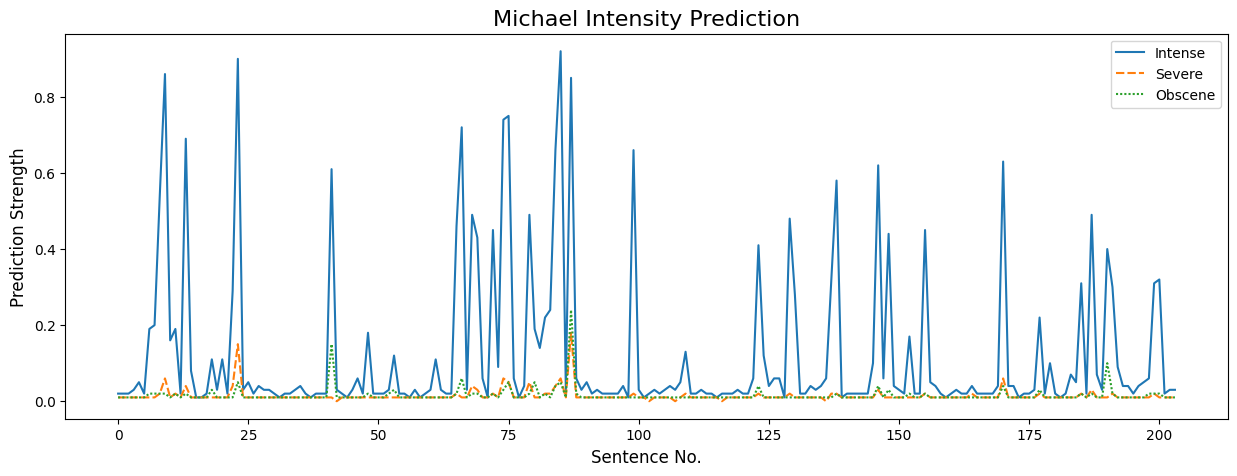

In [38]:
sns.lineplot(data=michael_df[['Intense', 'Severe', 'Obscene']])
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength',fontsize=12)
plt.title("Michael Intensity Prediction",fontsize=16)
plt.show()

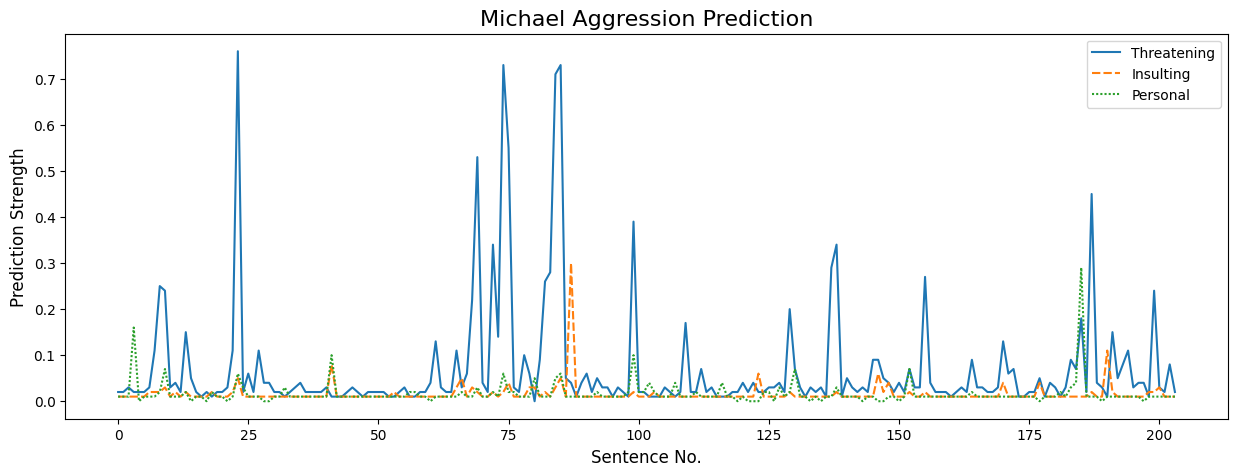

In [39]:
sns.lineplot(data=michael_df[['Threatening', 'Insulting', 'Personal']]) # palette=['red', 'yellow', 'orange'])
plt.xlabel('Sentence No.',fontsize=12)
plt.ylabel('Prediction Strength',fontsize=12)
plt.title("Michael Aggression Prediction",fontsize=16)
plt.show()

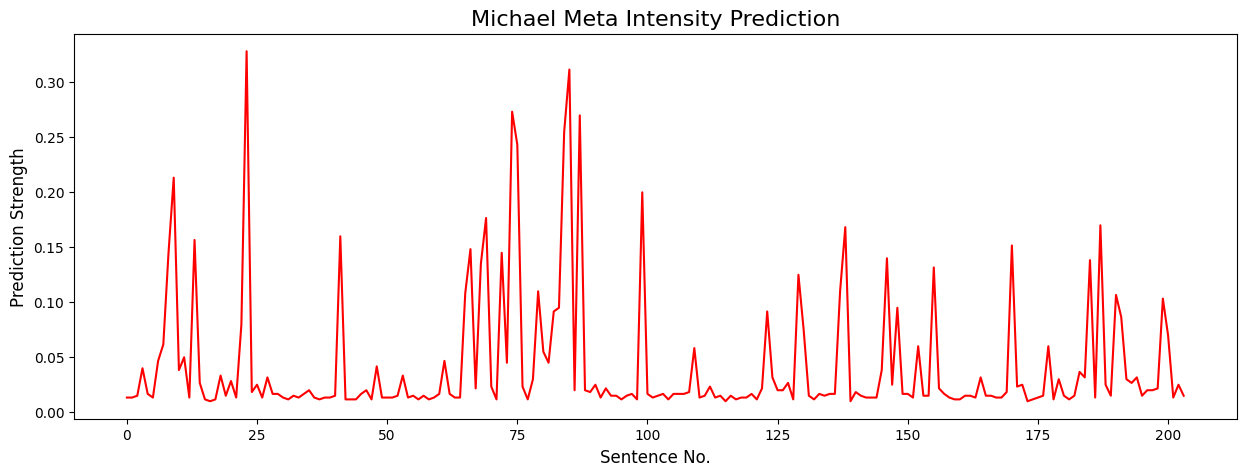

In [46]:
sns.lineplot(data=michael_df['meta_intensity'],color='red')
plt.xlabel('Sentence No.',fontsize=12)
plt.ylabel('Prediction Strength',fontsize=12)
plt.title("Michael Meta Intensity Prediction", fontsize=16)
plt.show()

In [41]:
# Peak intensity/aggression dialogue
michael_df.iloc[65:76]

,Intense,Severe,Obscene,Threatening,Insulting,Personal,meta_intensity,Dialogue
65,0.46,0.02,0.02,0.11,0.03,0.01,0.108333,You just stand here one minute...
66,0.72,0.01,0.06,0.03,0.05,0.02,0.148333,"Sonny...Sonny--Jesus Christ, I'm down at the hospital. I came down late. There's no one here. None of Tessio's people--no detectives, no one. The old man is completely unprotected."
67,0.03,0.01,0.01,0.06,0.01,0.01,0.021667,"(furiously, but kept inside) I won't panic."
68,0.49,0.04,0.02,0.22,0.03,0.01,0.135000,(coldly) You and I are going to move my father right now...to another room on another floor...Can you disconnect those tubes so we can wheel the bed out?
69,0.43,0.03,0.02,0.53,0.02,0.03,0.176667,You've read about my father in the papers. You've seen that no one's here to guard him. Now I've just gotten word that men are coming to this hospital to kill him. Believe me and help me.
70,0.06,0.01,0.01,0.04,0.01,0.01,0.023333,"Hurry, into there."
71,0.01,0.01,0.01,0.02,0.01,0.01,0.011667,(stepping out) Who is it?
72,0.45,0.02,0.02,0.34,0.02,0.02,0.145000,"Enzo, get out of here. There's going to be trouble."
73,0.09,0.01,0.01,0.14,0.01,0.01,0.045000,Go outside; stand in front...I'll be out in a minute.
74,0.74,0.06,0.03,0.73,0.02,0.06,0.273333,"Pop...Pop, it's me Michael. Shhhh, don't try to speak. There are men who are coming to try to kill you. But I'm with you...I'm with you now..."


# Hagen Predictions Plotted
- Intense, Severe, Obscene
- Threatening, Insulting, Personal
- Meta Intensity

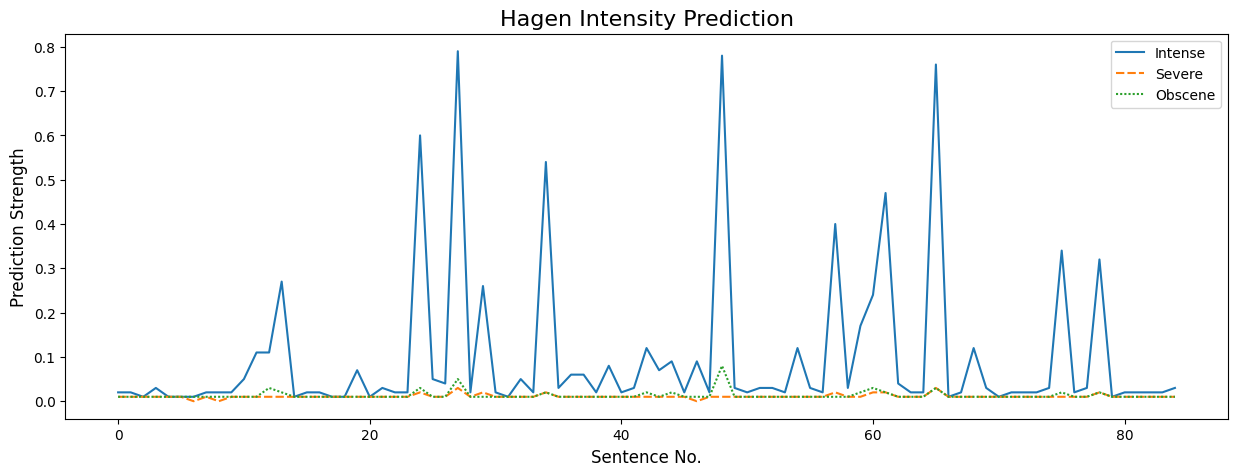

In [42]:
sns.lineplot(data=hagen_df[['Intense', 'Severe', 'Obscene']])
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Hagen Intensity Prediction", fontsize=16)
plt.show()

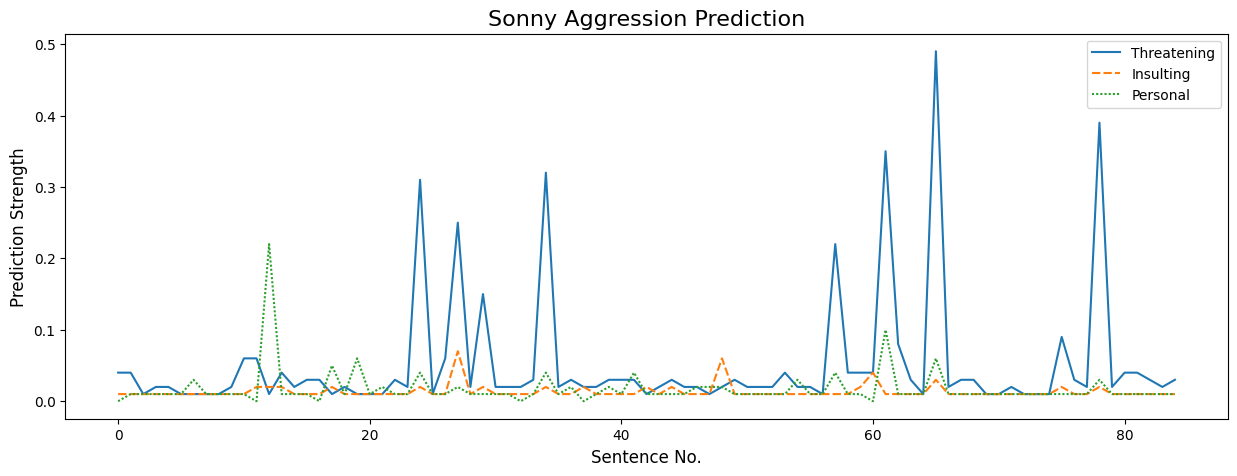

In [43]:
sns.lineplot(data=hagen_df[['Threatening', 'Insulting', 'Personal']])
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Sonny Aggression Prediction", fontsize=16)
plt.show()

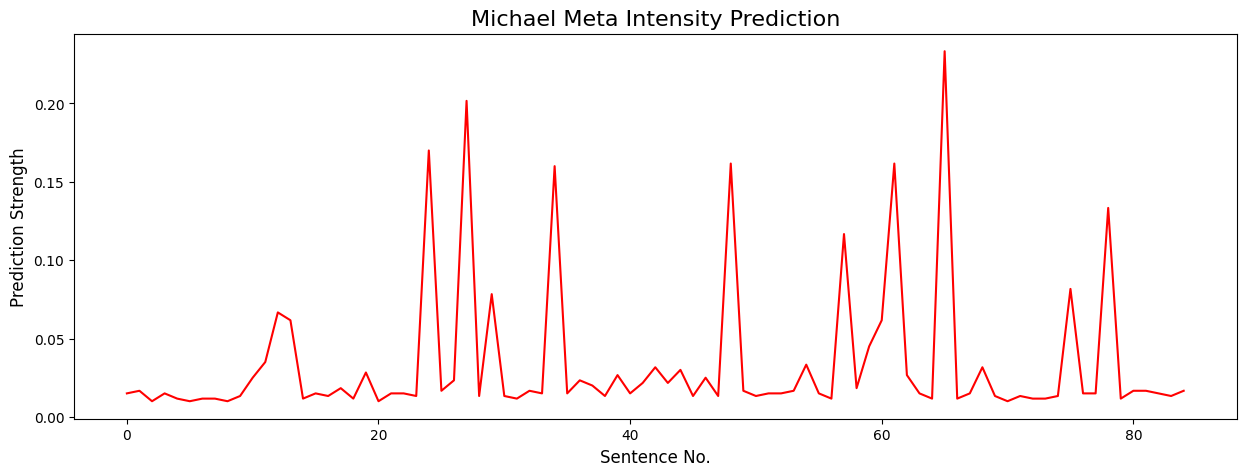

In [45]:
sns.lineplot(data=hagen_df['meta_intensity'], color='red')
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Michael Meta Intensity Prediction", fontsize=16)
plt.show()

In [47]:
# Hagen peak intensity/aggression
hagen_df.iloc[57:72]

,Intense,Severe,Obscene,Threatening,Insulting,Personal,meta_intensity,Dialogue
57,0.40,0.02,0.01,0.22,0.01,0.04,0.116667,Michael... (he takes a breath) It was Michael who killed Sollozzo.
58,0.03,0.01,0.01,0.04,0.01,0.01,0.018333,He's safe now...we're already working on ways to bring him back.
59,0.17,0.01,0.02,0.04,0.02,0.01,0.045000,"You start operating, the five families will start their raids again. We're at a stalemate Sonny, your war is costing us a lot of money."
60,0.24,0.02,0.03,0.04,0.04,0.00,0.061667,"Yes. That's true, you're getting a hell of a reputation."
61,0.47,0.02,0.02,0.35,0.01,0.10,0.161667,Go after him.
62,0.04,0.01,0.01,0.08,0.01,0.01,0.026667,(quietly) OK. Go to Clemenza's house and tell him to come here right away. He'll tell you what to do.
63,0.02,0.01,0.01,0.03,0.01,0.01,0.015000,(quietly) I didn't tell Mama anything. I was about to come up and wake you and tell you. Just now.
64,0.02,0.01,0.01,0.01,0.01,0.01,0.011667,Yes.
65,0.76,0.03,0.03,0.49,0.03,0.06,0.233333,They shot Sonny on the Causeway. (pause) He's dead.
66,0.01,0.01,0.01,0.02,0.01,0.01,0.011667,"This is Tom Hagen; I'm calling for Don Corleone, at his request."


# Sonny Predictions Plotted
- Intense, Severe, Obscene
- Threatening, Insulting, Personal
- Meta Intensity

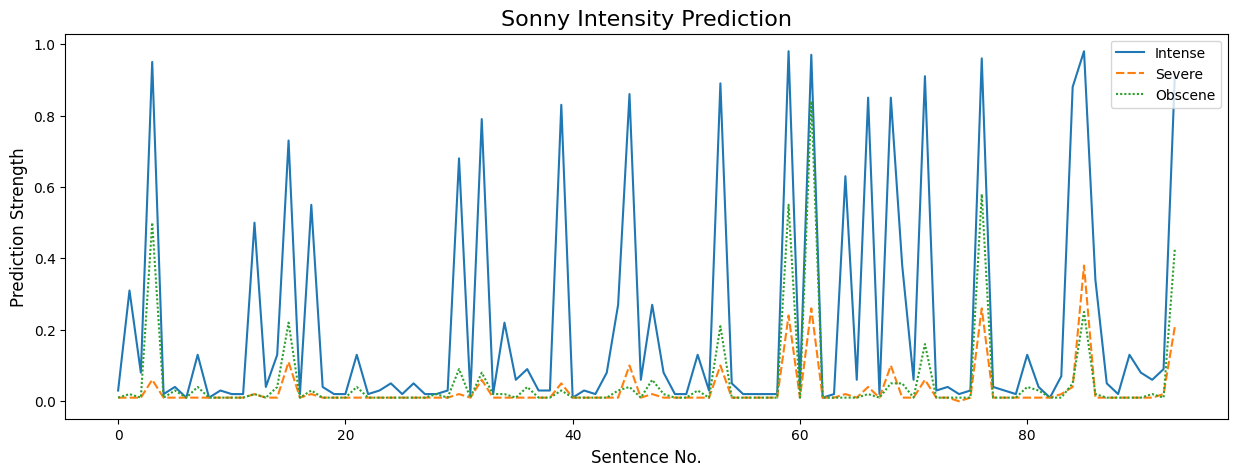

In [48]:
sns.lineplot(data=sonny_df[['Intense', 'Severe', 'Obscene']])
plt.legend(loc='upper right')
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Sonny Intensity Prediction", fontsize=16)
plt.show()

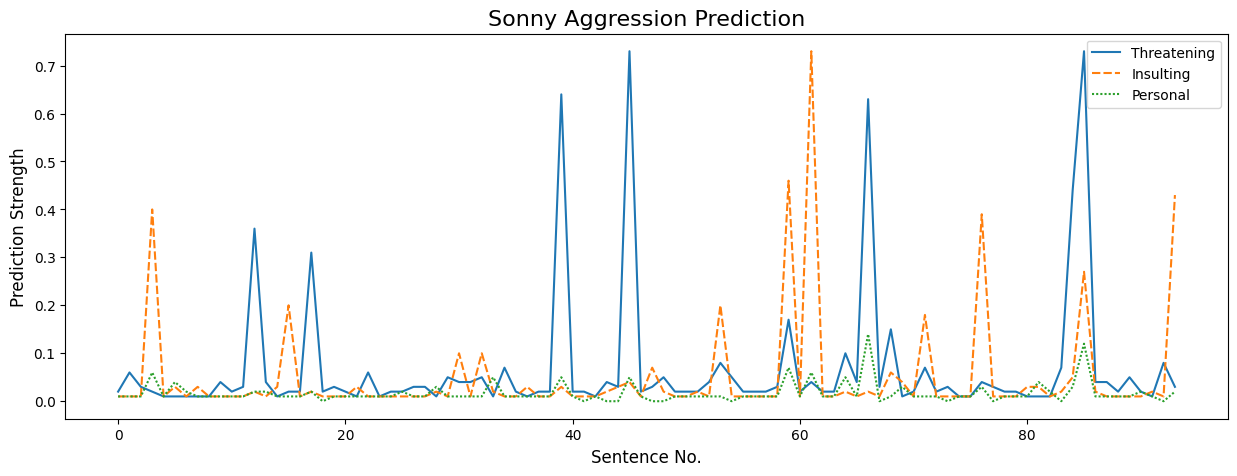

In [49]:
sns.lineplot(data=sonny_df[['Threatening', 'Insulting', 'Personal']])
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Sonny Aggression Prediction", fontsize=16)
plt.show()

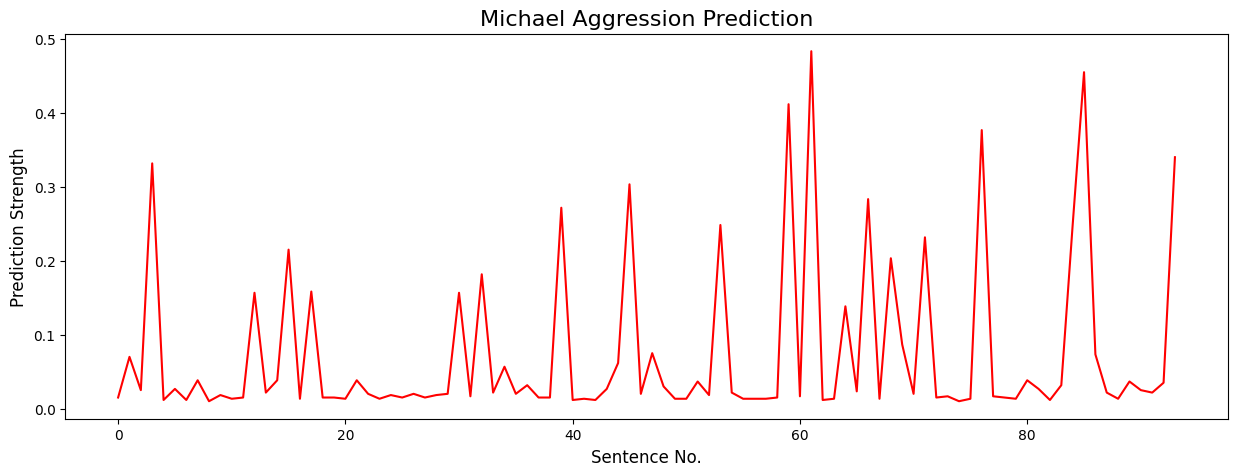

In [51]:
sns.lineplot(data=sonny_df['meta_intensity'],color='red')
plt.xlabel('Sentence No.', fontsize=12)
plt.ylabel('Prediction Strength', fontsize=12)
plt.title("Michael Aggression Prediction", fontsize=16)
plt.show()

In [52]:
# Peak threatening dialogue
sonny_df.iloc[55:65]

,Intense,Severe,Obscene,Threatening,Insulting,Personal,meta_intensity,Dialogue
55,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,You take care of Paulie?
56,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,Where are you going?
57,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,(to Clemenza; dipping bread into the sauce) Send some bodyguards.
58,0.02,0.01,0.01,0.03,0.01,0.01,0.015000,"OK, but be careful."
59,0.98,0.24,0.55,0.17,0.46,0.07,0.411667,I've got a hundred button men on the streets twenty-four hours a day. If Sollozzo shows one hair on his ass he's dead.
60,0.04,0.01,0.01,0.02,0.01,0.01,0.016667,"Mikey, you look beautiful!"
61,0.97,0.26,0.84,0.04,0.73,0.06,0.483333,The Turk wants to talk! The nerve of that son of a bitch! After he craps out last night he wants a meet.
62,0.01,0.01,0.01,0.02,0.01,0.01,0.011667,"Sure, he wants us to send Mike to meet him to hear his proposition. The promise is the deal will be so good we can't refuse."
63,0.02,0.01,0.01,0.02,0.01,0.01,0.013333,Part of the deal: Bruno cancels out what they did to my father.
64,0.63,0.02,0.01,0.10,0.02,0.05,0.138333,"No, no Consiglere. Not this time. No more meetings, no more discussions, no more Sollozzo tricks. Give them one message: I WANT SOLLOZZO. If not, it's all out war. We go to the mattresses and we put all the button men out on the street."


# Take Aways
- "Toxicicity" is not the ideal label set as the result tend to overclaassify for this label however the results as an "Intensity" prediction soften this and appear to be more semantically suitable particularly in regards to the project goal
- Can't plot the characters against each other as their scenes where not parsed chronolgically with respect to one another. Next step will parse scenes and then dialogue for this ability and to classify the scene context itself
- While on a granular level the individual sentences lose the semantic context and have low scores the peaks of impactful sentences nullify this somewhat and when plotted on a graph the generally intensity of "intense" scenes is visible 
- Generally impressed with the robust results achieved with a relativly simplictic model architecture


# Areas for Imporovement
- The "identity_hate" has inconsitent results and tends to overclassify and could benifit from another sampling technuique though changing it to "personal" suits
- Could clean the dataframe a bit as it contains many inconsitencies special characters, spaces etc..
- Could try BCEWithLogitLoss to modify the loss function based on predefined class weights